### Import Section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
import mplleaflet

plt.style.use('ggplot') 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
edgesDF = pd.read_excel("MadridMetroDataset.xlsx",sheet_name='Edges' )

In [3]:
edgesDF.head()

From   To Line  Weight
0   153  152    1   7.125
1   152  151    1   7.125
2   151  101    1   7.125
3   101  102    1   7.125
4   102  103    1   7.125

In [4]:
edgesDF.Line.unique()

array([1, 2, 3, 4, 5, 6, '7b', 7, 8, 9, '9b', '10b', 10, 11, 12, 'R'],
      dtype=object)

In [5]:
nodesDF = pd.read_excel('MadridMetroDataset.xlsx',sheet_name='Nodes')
print(nodesDF.shape)
nodesDF.head()

(242, 14)


StationID          StationName  Entries  Utilization  NumberLines  \
0       1102             Abrantes   838992      1460425            1   
1        519              Acacias  1411894      4098463            1   
2        806  Aeropuerto T1-T2-T3  2879690      3738740            1   
3        808        Aeropuerto T4  1758401      2913657            1   
4        552     Alameda de Osuna  1336992      3110859            1   

    Latitude  Longitude           Coordinates  LatHour  LatMin  LatSec  \
0  40.381667  -3.726944  40°22′54″N 3°43′37″O       40      22      54   
1  40.405000  -3.702778  40°24′18″N 3°42′10″O       40      24      18   
2  40.468056  -3.570556  40°28′05″N 3°34′14″O       40      28       5   
3  40.491389  -3.594167  40°29′29″N 3°35′39″O       40      29      29   
4  40.456389  -3.587222  40°27′23″N 3°35′14″O       40      27      23   

   LonHour  LonMin  LonSec  
0        3      43      37  
1        3      42      10  
2        3      34      14  
3        3      35      39  
4        3      35      14

In [6]:
nodesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StationID    242 non-null    int64  
 1   StationName  242 non-null    object 
 2   Entries      242 non-null    int64  
 3   Utilization  242 non-null    int64  
 4   NumberLines  242 non-null    int64  
 5   Latitude     242 non-null    float64
 6   Longitude    242 non-null    float64
 7   Coordinates  242 non-null    object 
 8   LatHour      242 non-null    int64  
 9   LatMin       242 non-null    int64  
 10  LatSec       242 non-null    int64  
 11  LonHour      242 non-null    int64  
 12  LonMin       242 non-null    int64  
 13  LonSec       242 non-null    int64  
dtypes: float64(2), int64(10), object(2)
memory usage: 26.6+ KB


In [7]:
len(nodesDF.StationID.unique())

242

### Graph Preparation

In [8]:
weightDF = edgesDF[['Line','From','To','Weight']]
weightDF['Weight'] = weightDF['Weight']*1000
weightDF.head()

Line  From   To  Weight
0    1   153  152  7125.0
1    1   152  151  7125.0
2    1   151  101  7125.0
3    1   101  102  7125.0
4    1   102  103  7125.0

In [9]:
weightDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Line    279 non-null    object 
 1   From    279 non-null    int64  
 2   To      279 non-null    int64  
 3   Weight  279 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 8.8+ KB


In [10]:
data = weightDF.loc[:,"From":].values.astype(int)
Madrid_tube = nx.Graph()
Madrid_tube.add_nodes_from(list(range(0,)))
Madrid_tube.add_weighted_edges_from(data,)

In [11]:
stationname_dict = {}
entries_dict = {}
utilization_dict = {}
numberlines_dict = {}
for key in nodesDF.StationID:
    stationname_dict[key] = nodesDF.loc[nodesDF.StationID == key,['StationName']].values[0][0]
    entries_dict[key]     = nodesDF.loc[nodesDF.StationID == key,['Entries']].values[0][0]
    utilization_dict[key] = nodesDF.loc[nodesDF.StationID == key,['Utilization']].values[0][0]
    numberlines_dict[key] = nodesDF.loc[nodesDF.StationID == key,['NumberLines']].values[0][0]
    
nx.set_node_attributes(Madrid_tube, stationname_dict, 'StationName')
nx.set_node_attributes(Madrid_tube, entries_dict, 'Entries')
nx.set_node_attributes(Madrid_tube, utilization_dict, 'Utilization')
nx.set_node_attributes(Madrid_tube, numberlines_dict, 'NumberLines')


In [12]:
graph_dict = dict(list(zip(['Madrid_tube'],
                      [Madrid_tube])))
for key in graph_dict:
    print(key)
    print(nx.info(graph_dict[key]))
    print()

Madrid_tube
Name: 
Type: Graph
Number of nodes: 242
Number of edges: 276
Average degree:   2.2810



In [13]:
edgesDF['line_colour'] = edgesDF['Line'].replace('7b','7')
edgesDF['line_colour'] = edgesDF['line_colour'].replace('9b','9')
edgesDF['line_colour'] = edgesDF['line_colour'].replace('10b','10')
edgesDF['line_colour'] = edgesDF['line_colour'].replace('R','13')
edgesDF['line_colour'] = edgesDF['line_colour'].astype(int)
linesDF = edgesDF[['From','To','line_colour']]
data = linesDF.loc[:,"From":].values.astype(int)
Madrid_tube.add_weighted_edges_from(data,weight='line')
CR = [Madrid_tube[u][v]['line'] for u, v in Madrid_tube.edges]
color = np.where(np.asarray(CR) == 1,"#30a3dc", CR).tolist()
color = np.where(np.asarray(color) == '2',"#cd031d", color).tolist()
color = np.where(np.asarray(color) == '3',"#ffe114", color).tolist()
color = np.where(np.asarray(color) == '4',"#944248", color).tolist()
color = np.where(np.asarray(color) == '5',"#96bf0d", color).tolist()
color = np.where(np.asarray(color) == '6',"#a0a5a7", color).tolist()
color = np.where(np.asarray(color) == '7',"#faa64a", color).tolist()
color = np.where(np.asarray(color) == '8',"#f27ca2", color).tolist()
color = np.where(np.asarray(color) == '9',"#a93094", color).tolist()
color = np.where(np.asarray(color) == '10',"#084594", color).tolist()
color = np.where(np.asarray(color) == '11',"#008b43", color).tolist()
color = np.where(np.asarray(color) == '12',"#a49a00", color).tolist()
color = np.where(np.asarray(color) == '13',"#093163", color).tolist()
weights = [Madrid_tube[u][v]['weight'] for u,v in Madrid_tube.edges]
entries = []
for number in [el[1] for el in list(Madrid_tube.nodes.data('Entries'))]:
    entries.append(number / 50000)

utilization = []
for number in [el[1] for el in list(Madrid_tube.nodes.data('Utilization'))]:
    utilization.append(number / 50000)
    
exits = (np.array(utilization) - np.array(entries)).tolist()

In [16]:
pos_dict = {}
for key in nodesDF.StationID:
    pos_dict[key] = list(nodesDF.loc[nodesDF.StationID == key,['Longitude','Latitude']].values[0])
pos_dict

{1102: [-3.7269444444444444, 40.38166666666667],
 519: [-3.702777777777778, 40.405],
 806: [-3.5705555555555555, 40.46805555555556],
 808: [-3.5941666666666667, 40.49138888888889],
 552: [-3.5872222222222225, 40.45638888888889],
 1203: [-3.8316666666666666, 40.35],
 413: [-3.667777777777778, 40.44833333333333],
 351: [-3.6983333333333337, 40.38333333333333],
 712: [-3.6991666666666667, 40.43833333333333],
 1219: [-3.736388888888889, 40.300555555555555],
 404: [-3.6958333333333337, 40.427499999999995],
 253: [-3.6236111111111113, 40.41833333333333],
 627: [-3.7380555555555555, 40.41],
 123: [-3.645277777777778, 40.38972222222222],
 527: [-3.7605555555555554, 40.38638888888889],
 105: [-3.7033333333333336, 40.45],
 114: [-3.6994444444444445, 40.41222222222222],
 718: [-3.7175000000000002, 40.47027777777778],
 927: [-3.4475000000000002, 40.30361111111111],
 608: [-3.6886111111111113, 40.39333333333333],
 310: [-3.716388888888889, 40.43055555555555],
 1217: [-3.7569444444444446, 40.2886111

In [59]:
Stationlabels=dict((n,d['StationName']) for n,d in Madrid_tube.nodes(data=True))
#Stationlabels.values()

### Madrid Metro Map with per people entriing stations

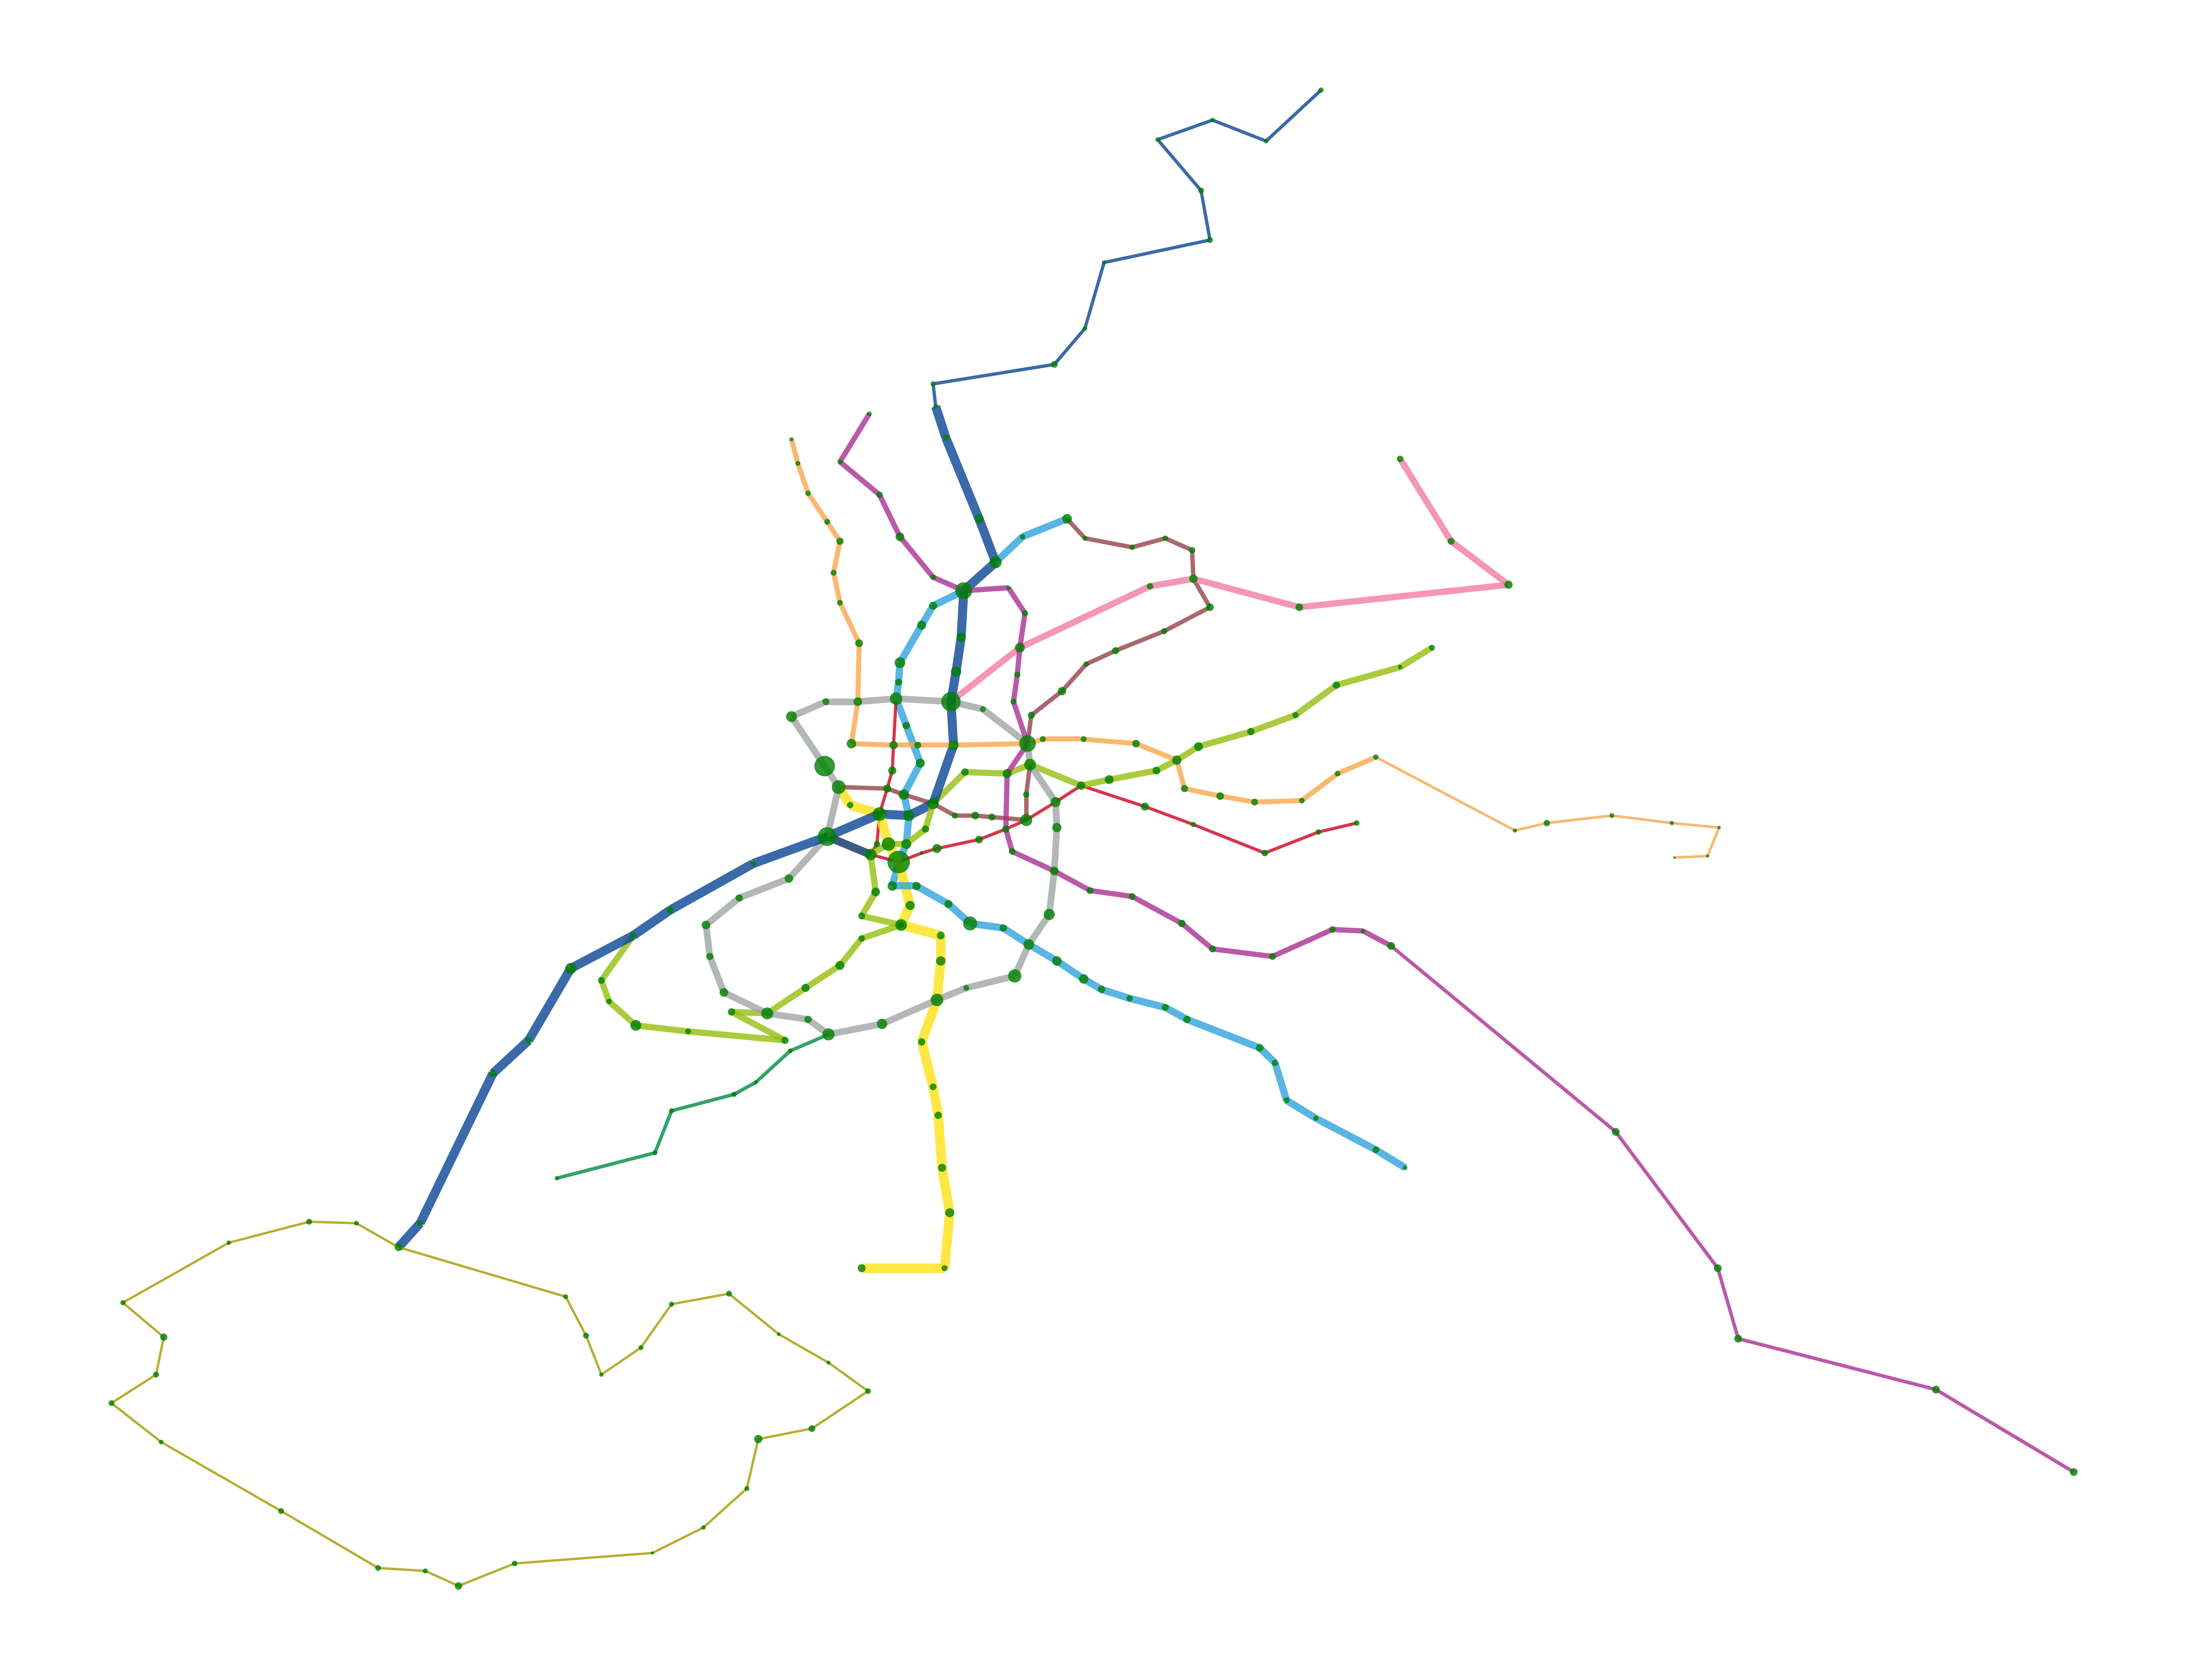

In [60]:
plt.figure(figsize=(30,23))
nx.draw(Madrid_tube,pos=pos_dict,node_size=entries,edge_color=color,node_color='g',
        width=(np.array(weights)/1000).tolist(),alpha=0.8)
plt.show()

### Madrid Metro Map with per people utilizing stations

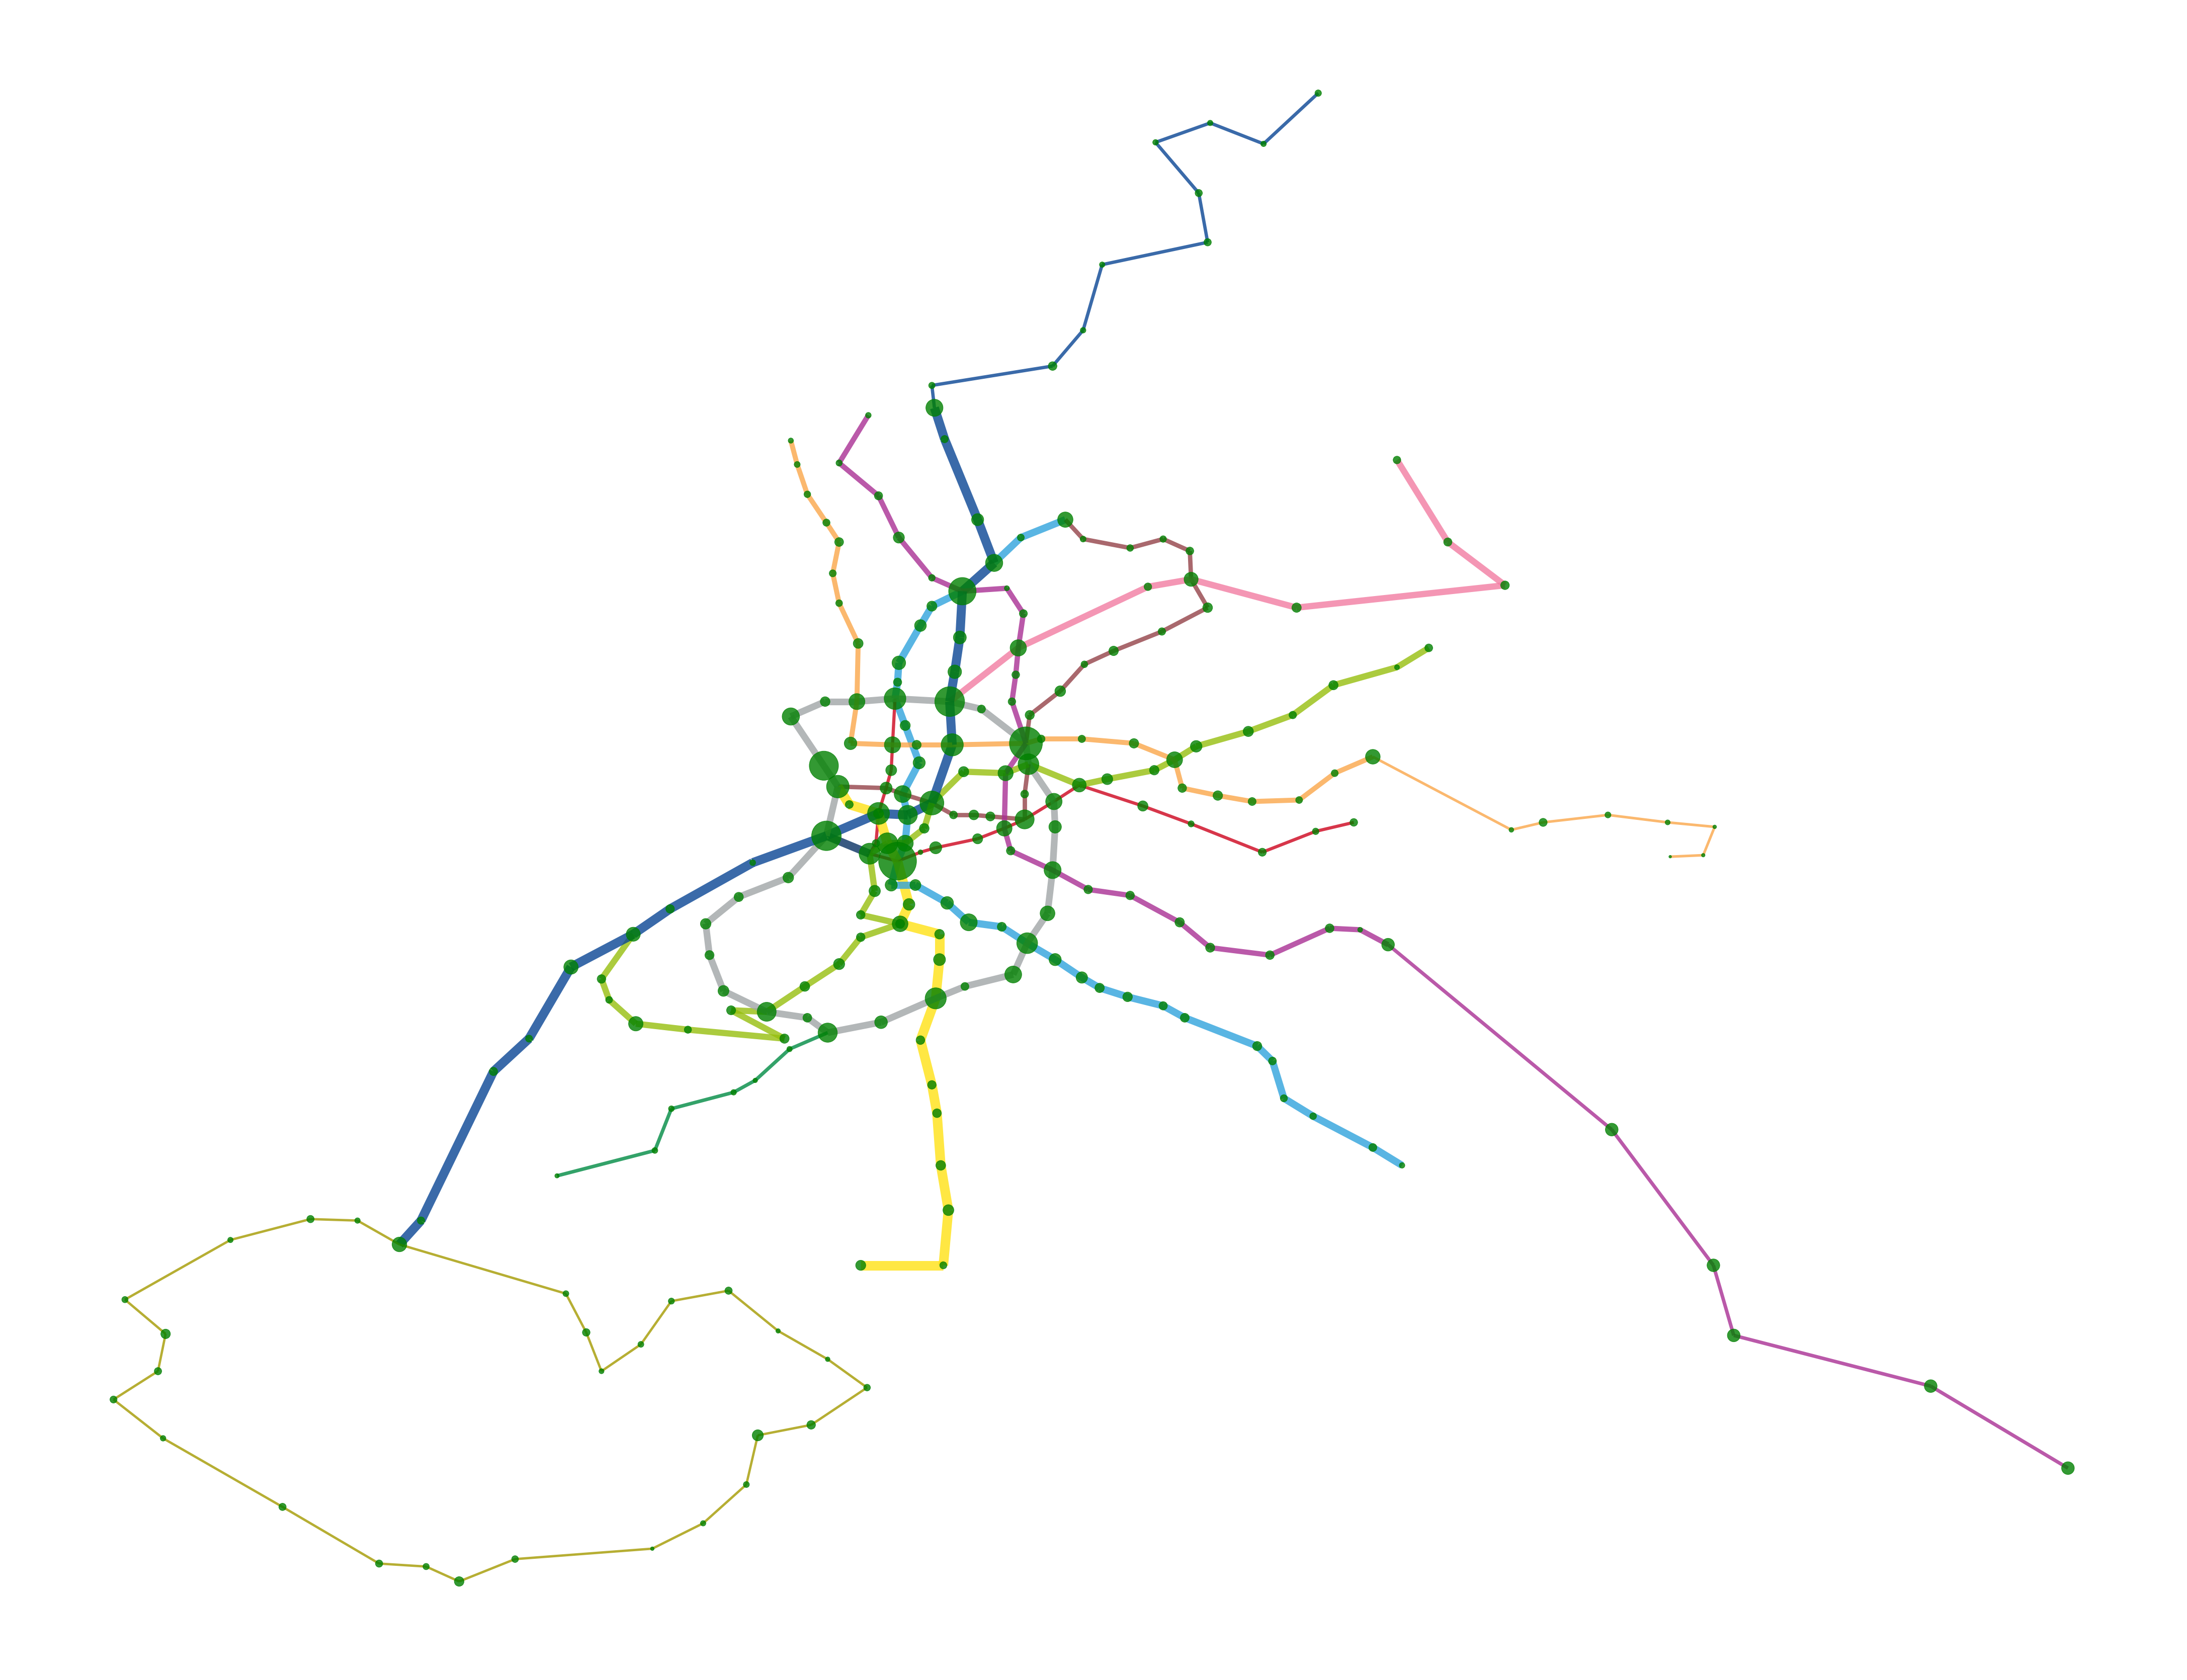

In [61]:
plt.figure(figsize=(30,23))
nx.draw(Madrid_tube,pos=pos_dict,node_size=utilization,edge_color=color,node_color='g',
        width=(np.array(weights)/1000).tolist(),alpha=0.8)
plt.show()

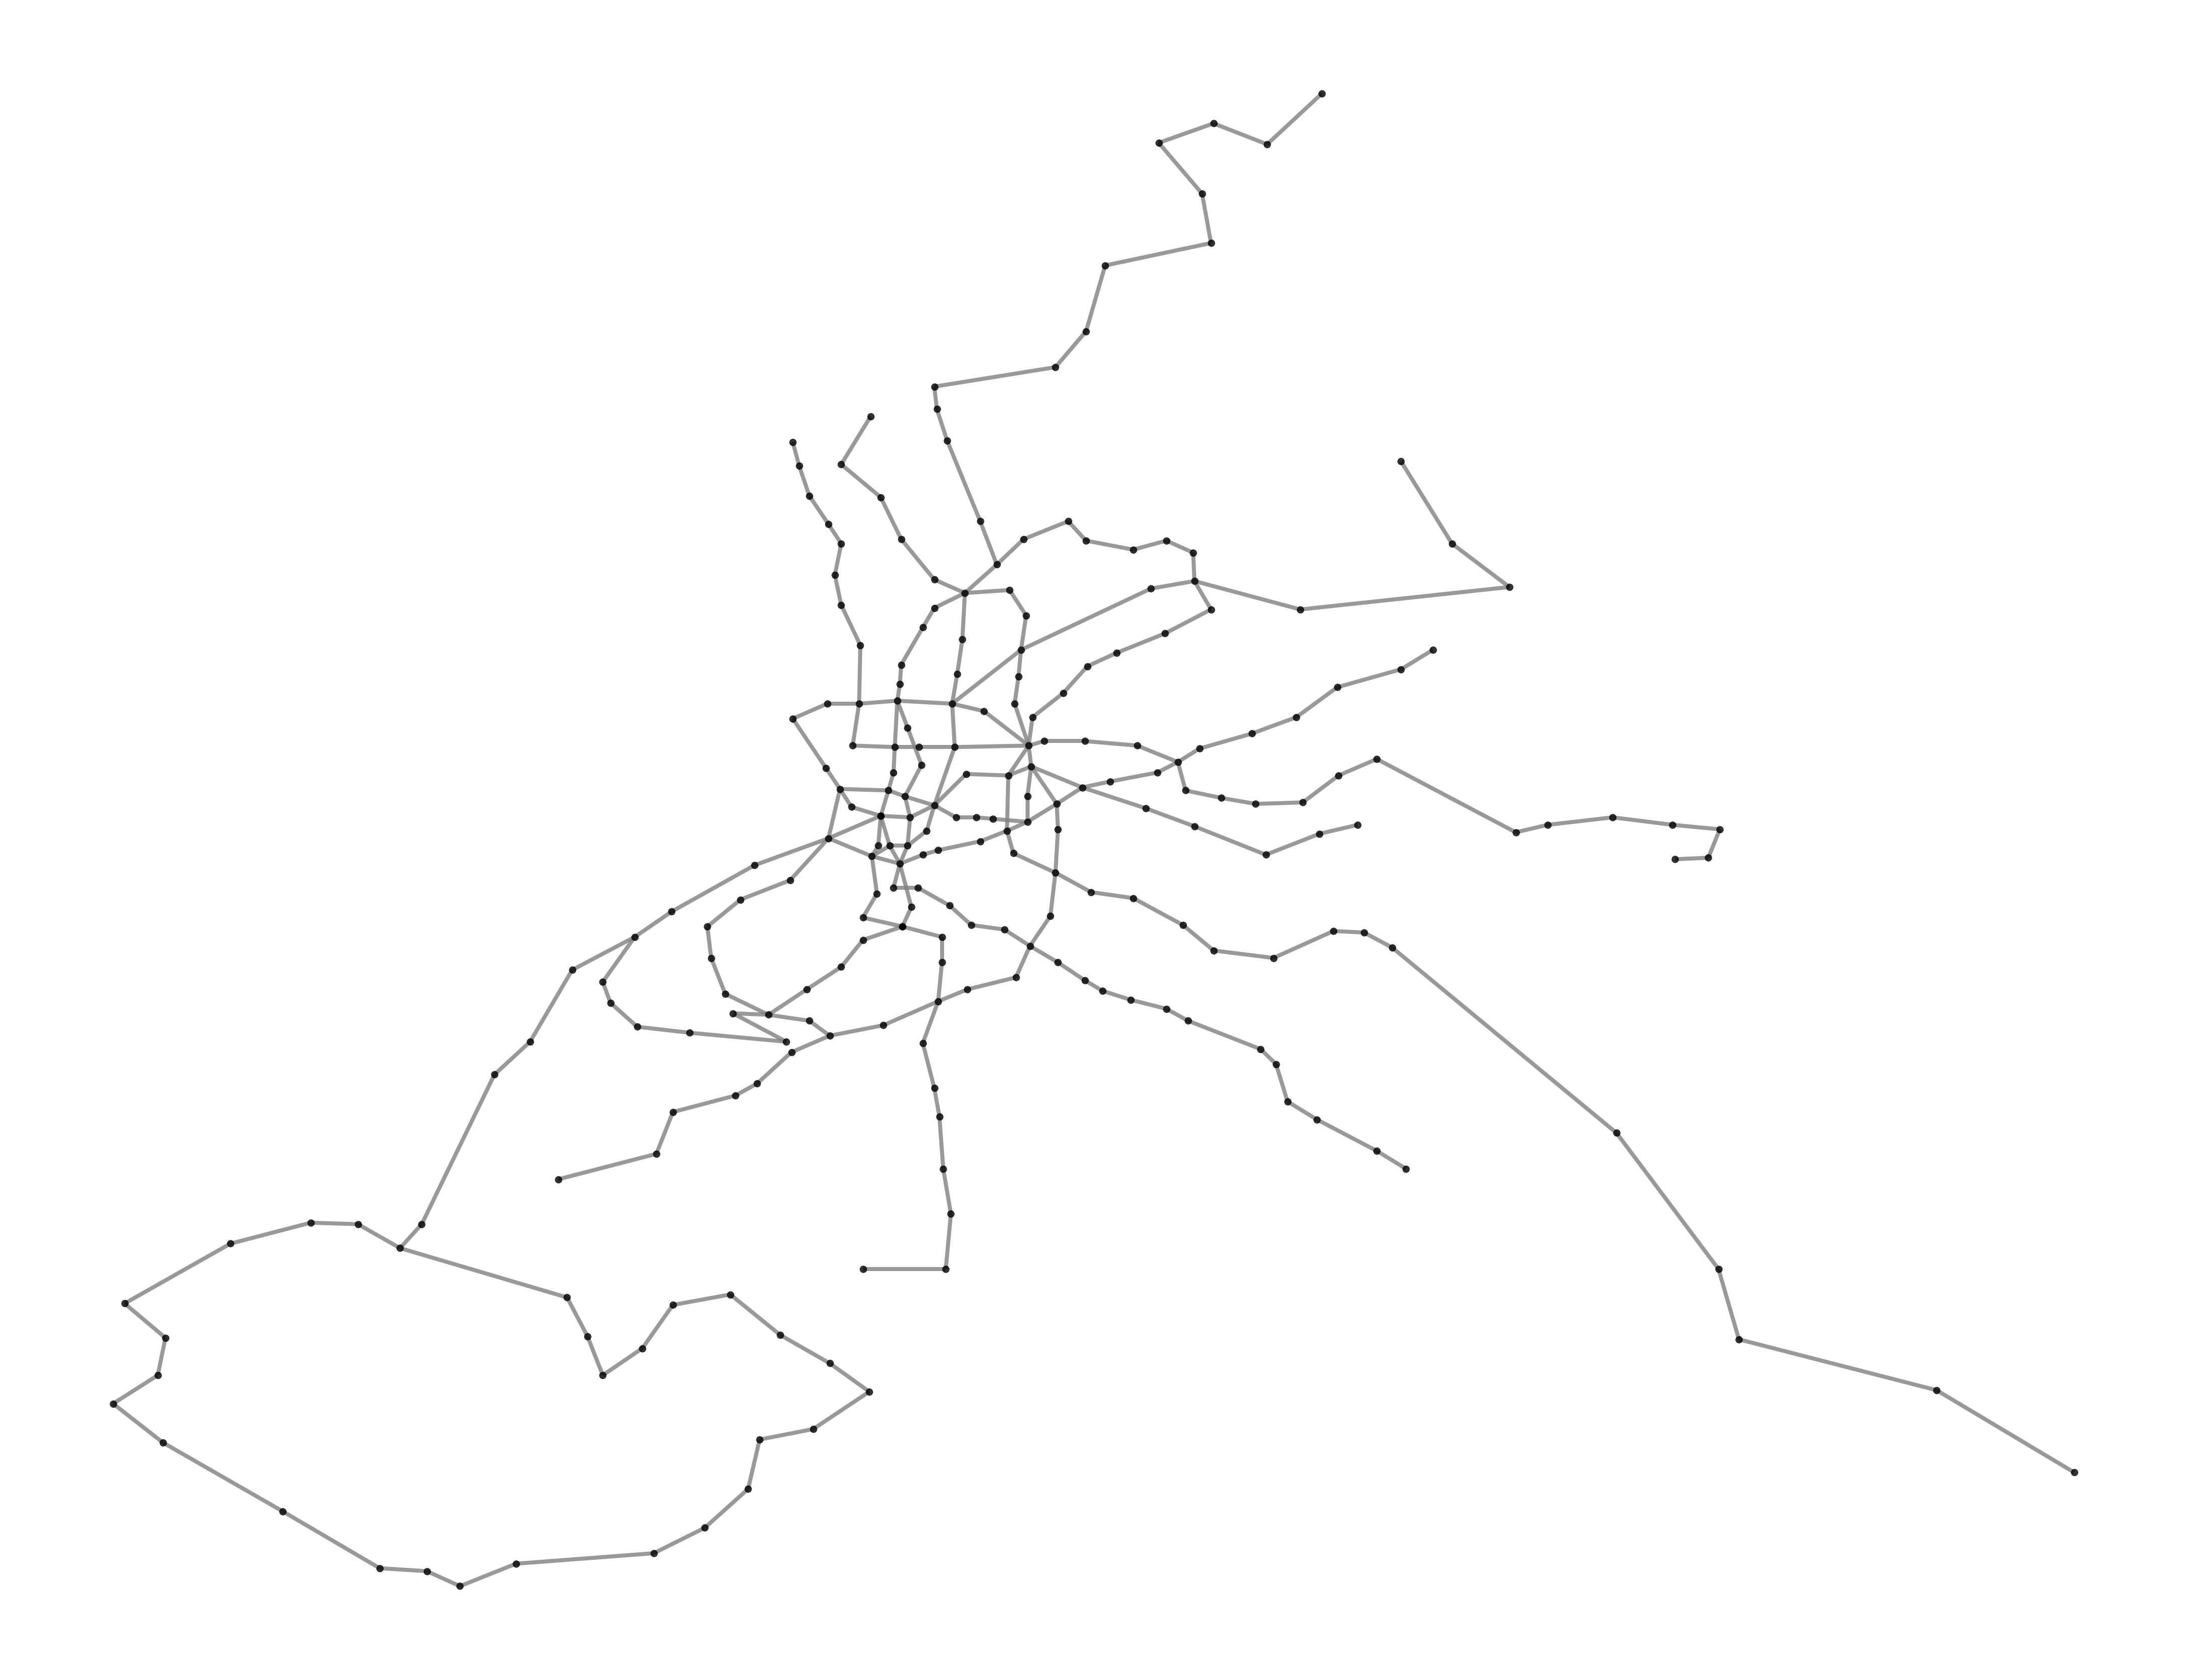

In [62]:
plt.figure(figsize=(30,23))
nx.draw(Madrid_tube,pos=pos_dict,node_size=45,edge_color='grey',node_color='black',
        width=4,alpha=0.8)
plt.show()

In [63]:
#!pip install mplleaflet
pos = pos_dict
labels = Stationlabels
fig, ax = plt.subplots(figsize=(10,10))
plt.style.use(['dark_background'])

nx.draw(Madrid_tube,pos=pos_dict,node_size=entries,edge_color=color,node_color='b',alpha=0.9
        ,width=(np.array(weights)/1500).tolist()
        ,labels=Stationlabels
       )

mplleaflet.display(fig=fig)

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


**How to get the shortest path between two stations?**

In [68]:
def find_shortest_path(Graph,df,FromStation,ToStation):
    nodecheck = 1
    try:
        start_node = int(df.StationID[df.StationName==FromStation])
    except:
        print('Your start point does not exist.')
        nodecheck = 0
    try:
        end_node = int(df.StationID[df.StationName==ToStation])
    except:
        print('Your start point does not exist.')
        nodecheck = 0
    if nodecheck == 1:
        try:
            pathlength = nx.shortest_path_length(Graph, start_node, end_node)
            path = nx.shortest_path(Graph, start_node, end_node)
            df.index = df['StationID']
            print("The shortest path from {} to {} crosses".format(FromStation,ToStation), end=' ') 
            print((', ').join(list(df.StationName[path])[1:-1])+".")
            print("The path length is", str(pathlength)+'.')
            print("You will have to take the following lines:")
            connection = list(df.StationID[nx.shortest_path(Graph, start_node, end_node)])
            lines = []
            conn_lst =[]
            for i in range(len(connection)-1):
                conn = list(weightDF.Line[((weightDF.From==connection[i]) & (weightDF.To==connection[i+1])) |
                        ((weightDF.From==connection[i+1]) & (weightDF.To==connection[i]))])
                if len(conn)>1:
                    conn = ' or ' + str(conn)
                else: 
                    conn = conn[0]
                #print(df.StationName[connection[i]])
                if conn not in lines and lines!=[]:
                    conn_lst.append(df.StationName[connection[i]])
                if conn not in lines:
                    lines.append(conn)
            print((str(lines)))
            print("You will have to change in:",conn_lst)
        except:
            print("There is no path between {} and {}.".format(FromStation,ToStation))
    df.reset_index(drop=True,inplace=True)        

In [70]:
FromStation = 'Acacias'
ToStation = 'Arganda del Rey'
find_shortest_path(Madrid_tube,nodesDF,FromStation,ToStation)

The shortest path from Acacias to Arganda del Rey crosses Puerta de Toledo, La Latina, Ópera, Sol, Sevilla, Banco de España, Retiro, Príncipe de Vergara, Ibiza, Sáinz de Baranda, Estrella, Vinateros, Artilleros, Pavones, Valdebernardo, Vicálvaro, San Cipriano, Puerta de Arganda, Rivas Urbanizaciones, Rivas Futura, Rivas Vaciamadrid, La Poveda.
The path length is 23.
You will have to take the following lines:
[5, 2, 9, '9b']
You will have to change in: ['Ópera', 'Príncipe de Vergara', 'Puerta de Arganda']


### Directed or  not  ?

In [23]:
nx.is_directed(Madrid_tube)

False

In [43]:
Madrid_tube.nodes

NodeView((153, 152, 151, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 255, 254, 253, 252, 251, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 357, 356, 355, 354, 353, 352, 351, 301, 302, 303, 304, 305, 307, 308, 309, 310, 311, 404, 405, 406, 407, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 552, 551, 501, 502, 503, 504, 505, 506, 507, 510, 511, 513, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 601, 602, 604, 605, 606, 608, 609, 611, 612, 613, 617, 618, 620, 621, 622, 625, 626, 627, 628, 760, 759, 758, 757, 756, 755, 754, 751, 701, 702, 703, 704, 705, 707, 708, 709, 711, 712, 714, 716, 717, 718, 719, 720, 721, 722, 723, 802, 803, 805, 806, 807, 808, 952, 951, 901, 902, 903, 905, 906, 908, 909, 913, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 1061, 1060, 1059, 1058, 1057, 1056, 1055, 1054, 1053, 1

### What is the Graph Diameter ?

In [24]:
diameter = nx.diameter(Madrid_tube)
print(nx.diameter(Madrid_tube))

44


### Articulation Nodes?

In [25]:
nodesDF['ArticulationNode'] = list(1*np.isin(list(nodesDF['StationID']),list(nx.articulation_points(Madrid_tube))))

articulation_dict = {}
for key in nodesDF.StationID:
    articulation_dict[key] = nodesDF.loc[nodesDF.StationID == key,['ArticulationNode']].values[0][0]
    
nx.set_node_attributes(Madrid_tube, articulation_dict, 'ArticulationNode')

In [26]:
len(list(nx.articulation_points(Madrid_tube)))

97

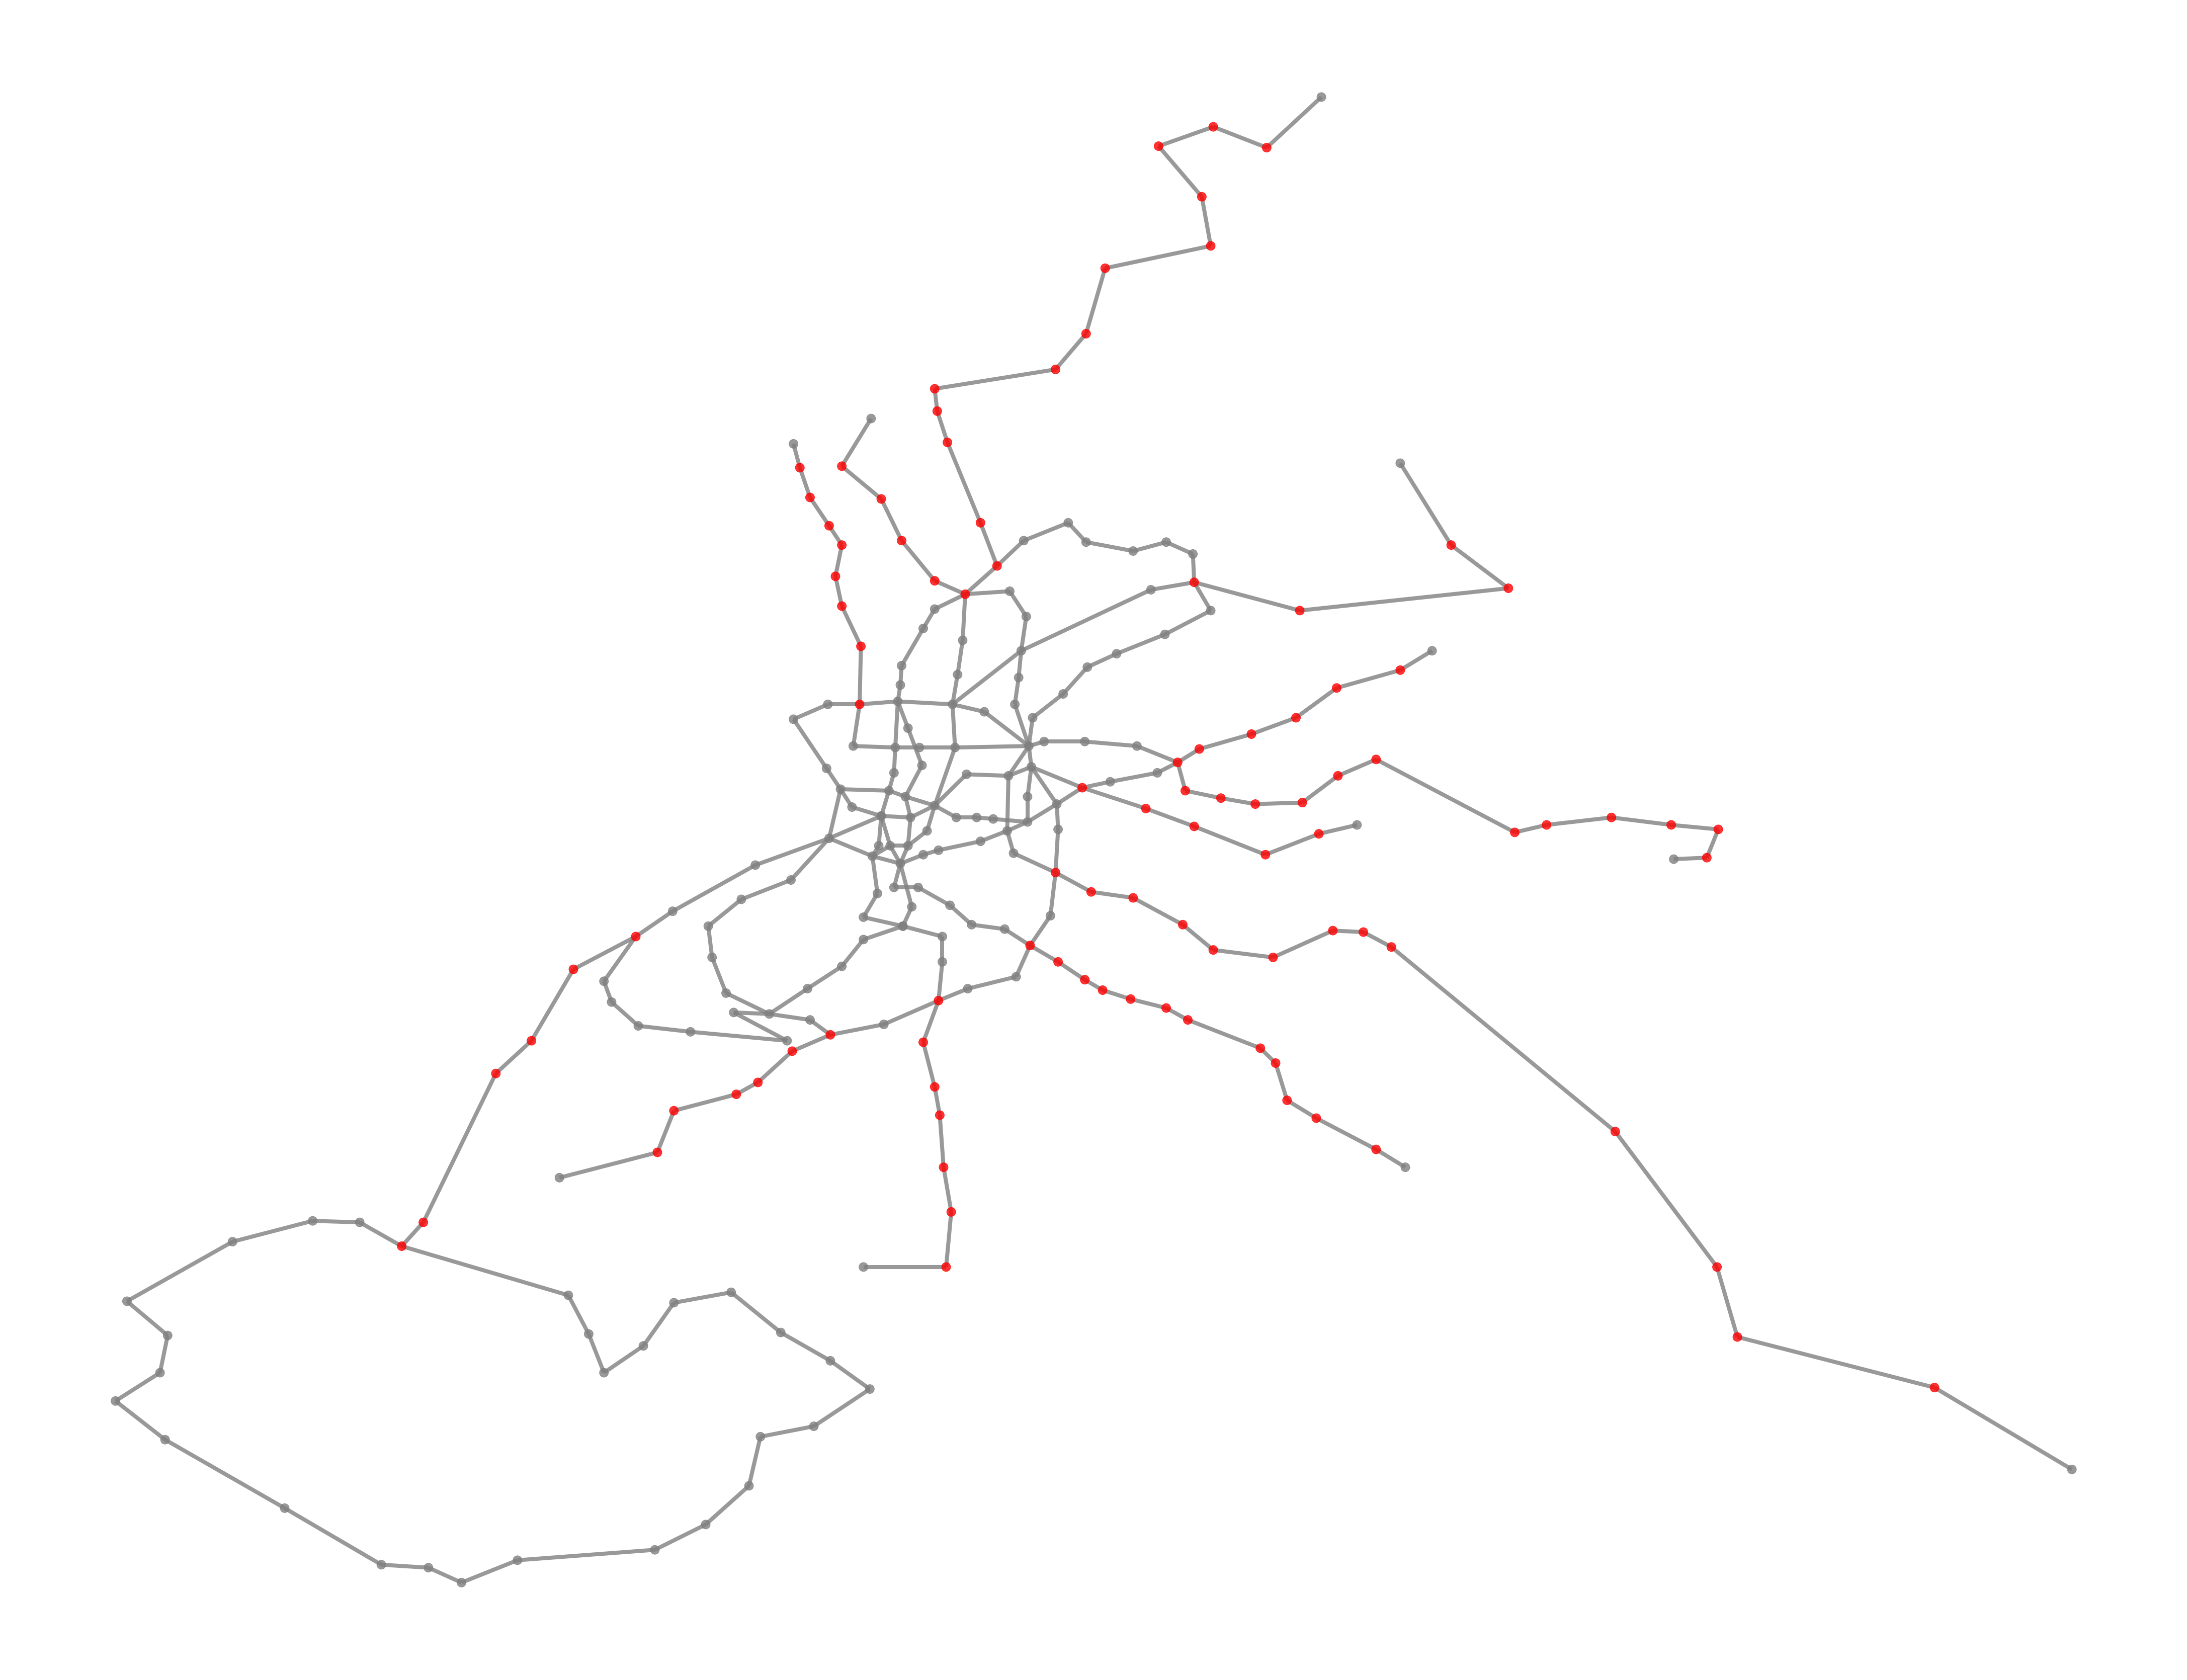

In [27]:
node_color = list(dict(Madrid_tube.nodes('ArticulationNode')).values())
node_color = np.where(np.asarray(node_color) == 1,"red", node_color).tolist()
node_color = np.where(np.asarray(node_color) == '0',"grey", node_color).tolist()

plt.figure(figsize=(30,23))
nx.draw(Madrid_tube,pos=pos_dict,node_size=80,node_color=node_color,
        width=4,edge_color="grey",alpha=0.8)
plt.show()

### Bridge Edges?

In [28]:
edgesDF['BridgeEdge'] = list((((np.isin(edgesDF['From'], list(list(zip(*list(nx.bridges(Madrid_tube))))[0]))*1) \
 + (np.isin(edgesDF['To'], list(list(zip(*list(nx.bridges(Madrid_tube))))[1]))*1)) == 2)*1)

bridge = edgesDF[['From','To','BridgeEdge']]
bridge = bridge.loc[:,"From":].values.astype(int)
Madrid_tube.add_weighted_edges_from(bridge,weight='bridgeEdge')

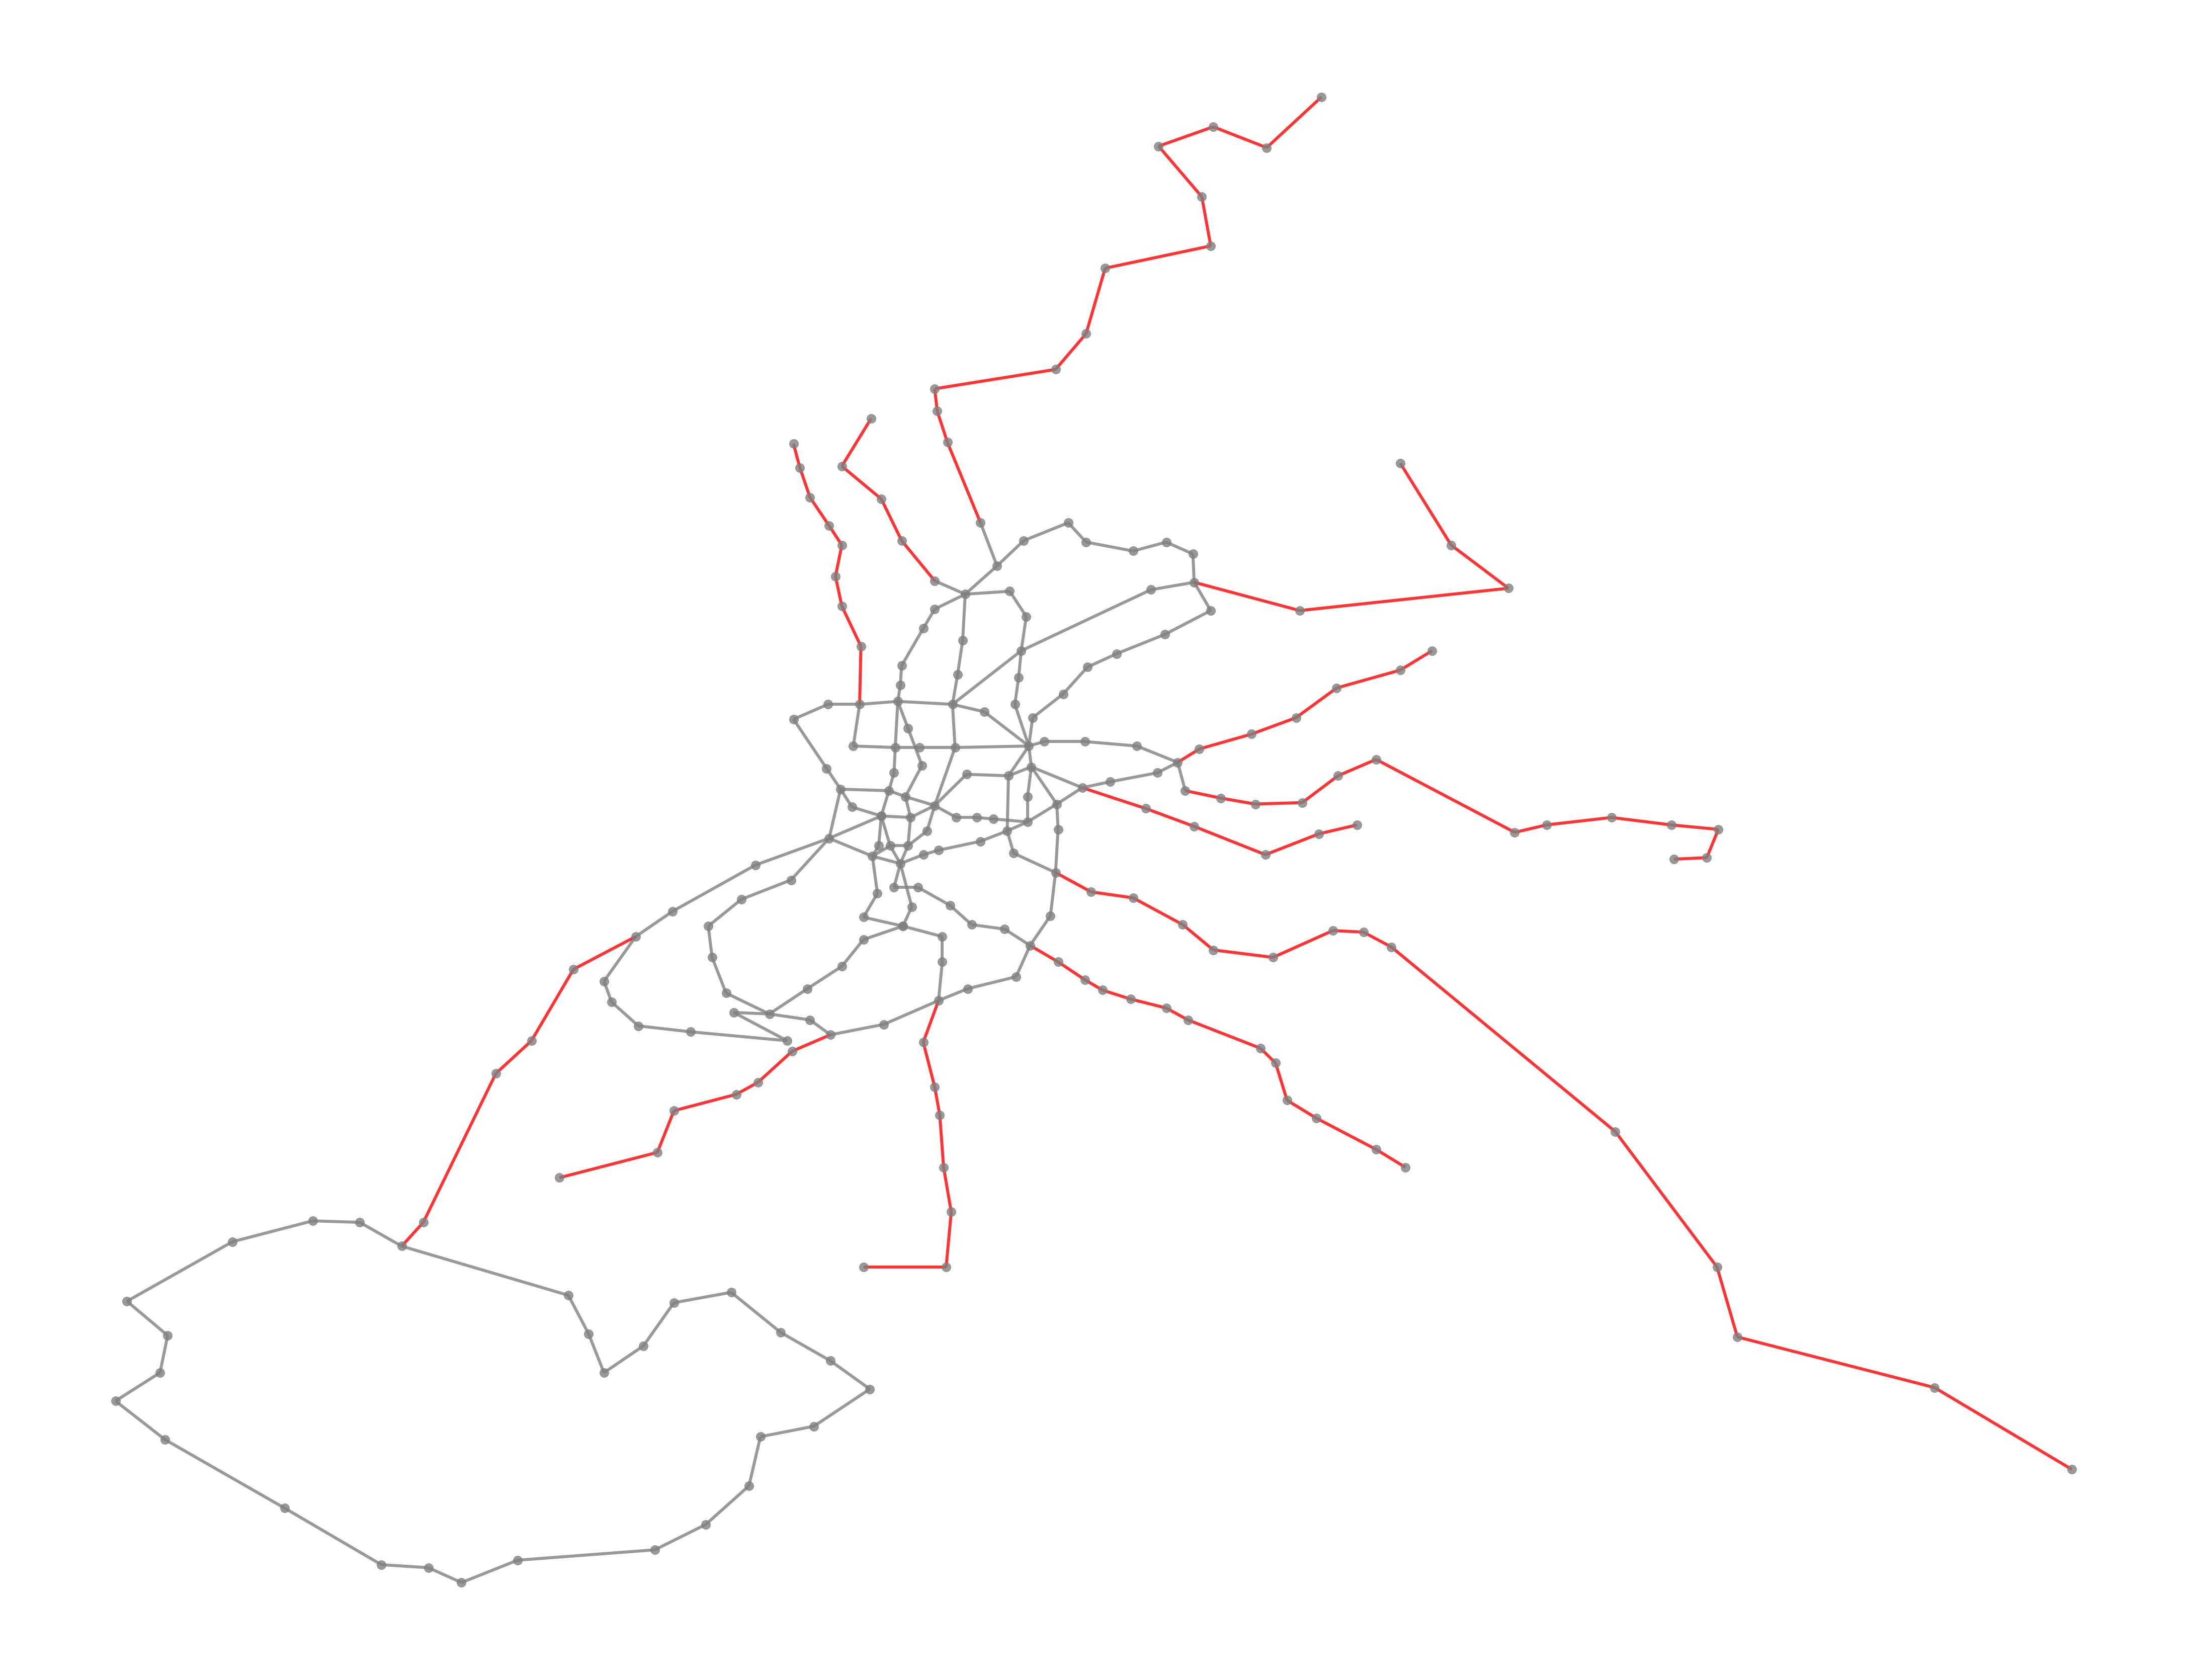

In [29]:
CR = [Madrid_tube[u][v]['bridgeEdge'] for u, v in Madrid_tube.edges]
color = np.where(np.asarray(CR) == 1,"red", CR).tolist()
color = np.where(np.asarray(color) == '0',"grey", color).tolist()

plt.figure(figsize=(30,23))
nx.draw(Madrid_tube,pos=pos_dict,node_size=80,node_color="grey",
        width=3,edge_color=color,alpha=0.8)
plt.show()

### What is the Degree distributions ?

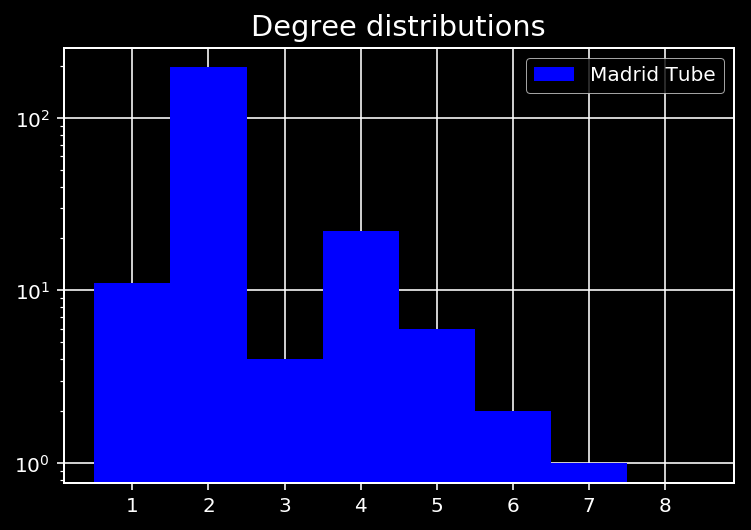

In [30]:
colors = ['blue']
plt.hist([list(dict(nx.degree(Madrid_tube)).values())],
         bins=np.linspace(0,8,9)+0.5,alpha=1,stacked=False,color=colors,label=colors)
plt.yscale('log')
plt.legend(['Madrid Tube'],prop={'size': 10})
plt.title('Degree distributions')
plt.show()

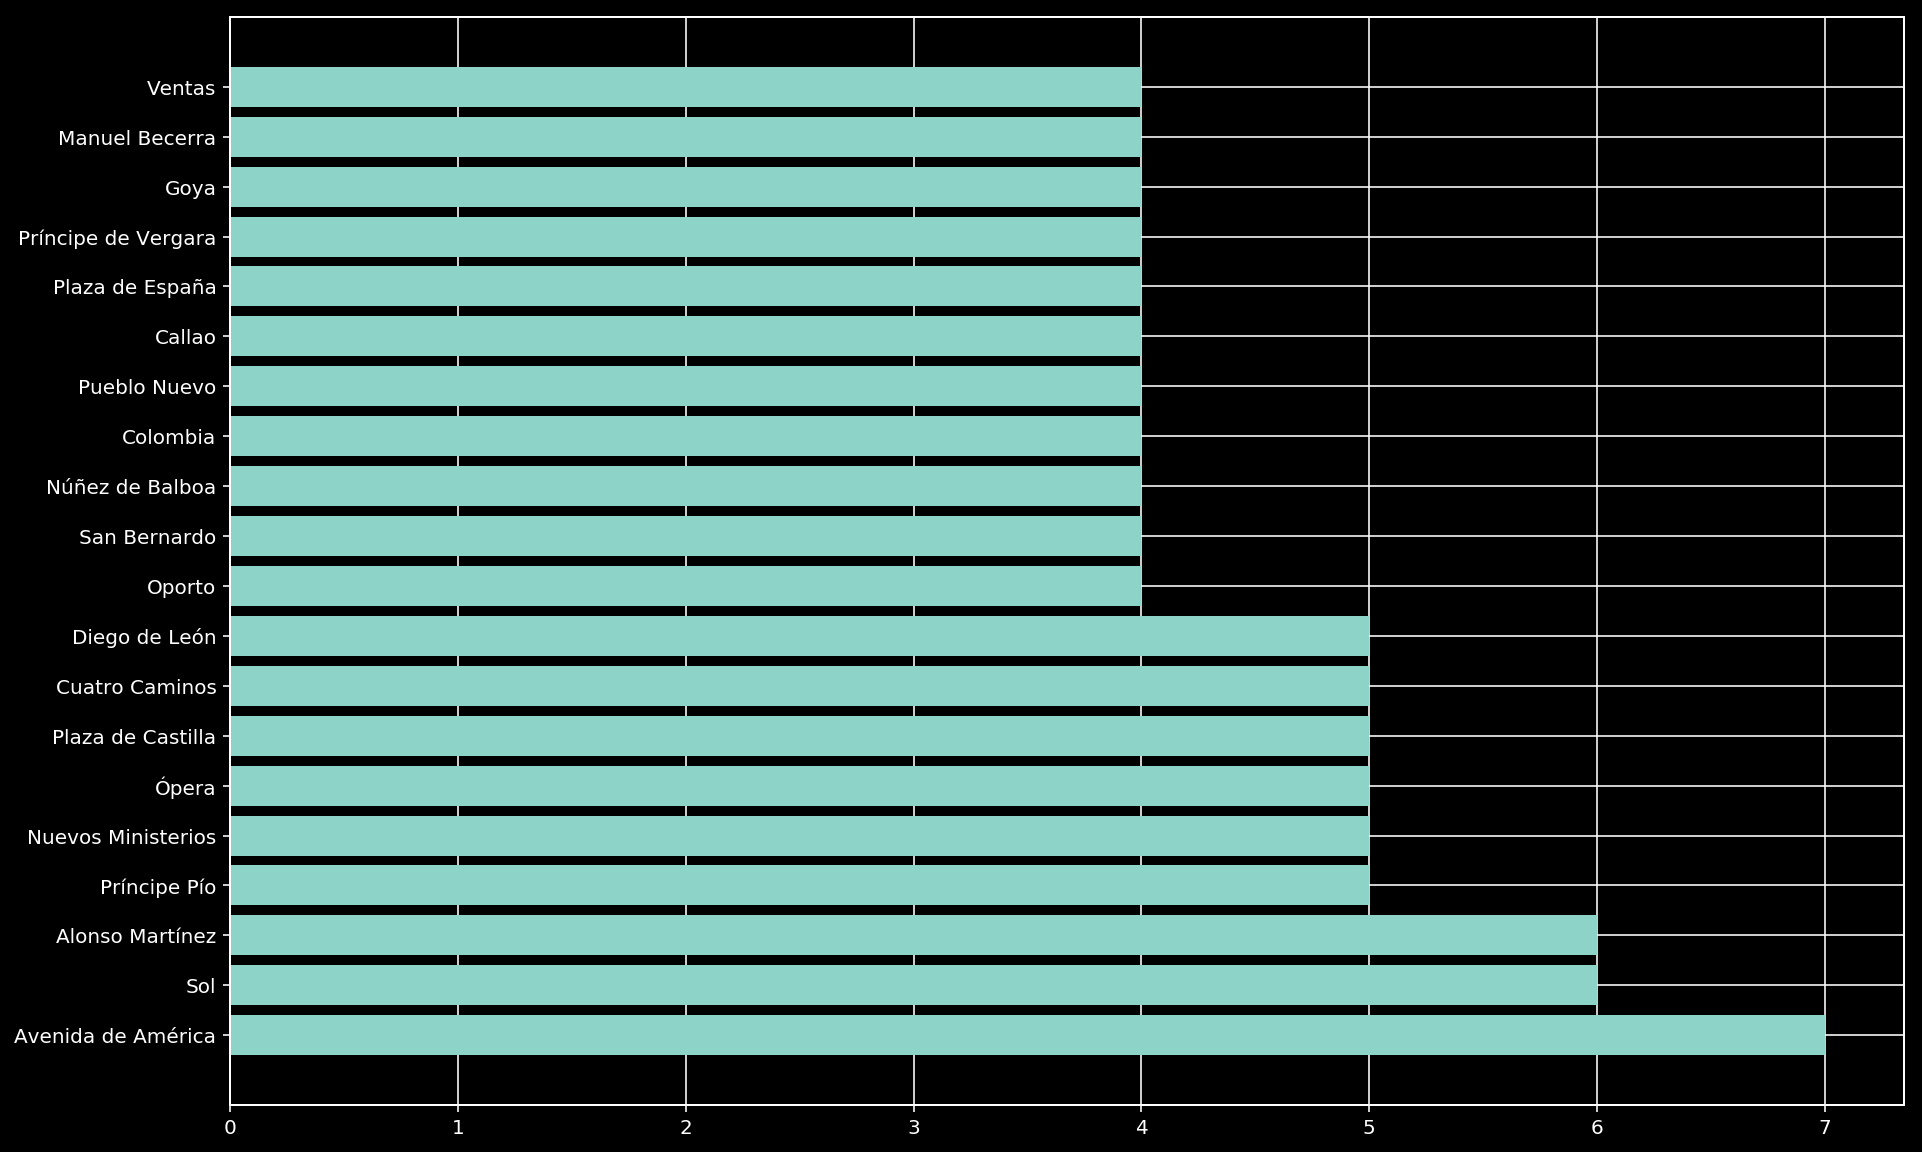

In [31]:
nodesDF = nodesDF.sort_values(by='StationID')
nodesDF['degree_centrality'] = list(dict(sorted(nx.degree(Madrid_tube))).values())
plt.figure(figsize=(15,10))
plt.barh(list(range(20)),nodesDF.sort_values(by='degree_centrality',ascending=False)
         .head(20).degree_centrality)
plt.yticks(list(range(20)),nodesDF.sort_values(by='degree_centrality',ascending=False).head(20).StationName)
plt.show()

### What is the Betweenness Centrality ?

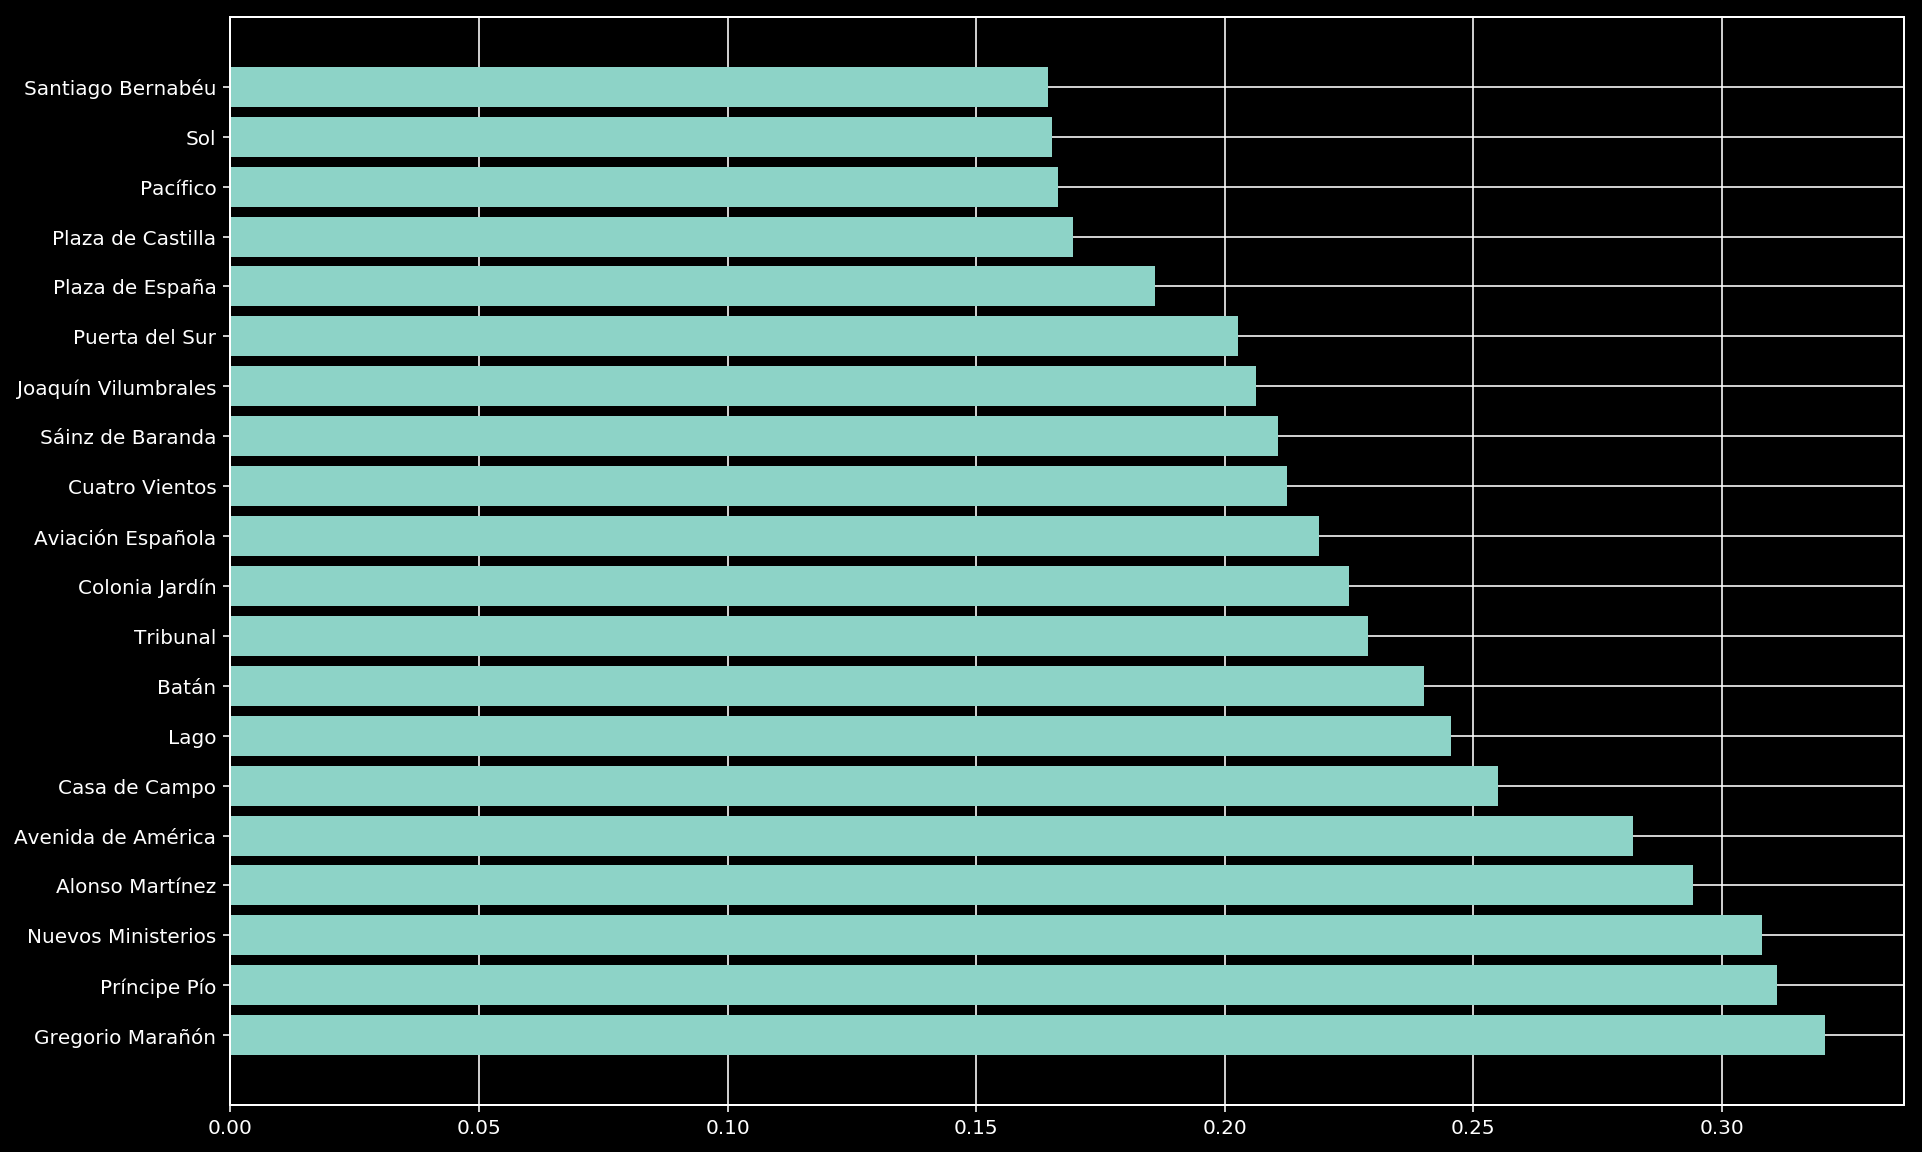

In [32]:
nodesDF = nodesDF.sort_values(by='StationID')
nodesDF['betweenness_centrality'] = list(dict(sorted(nx.betweenness_centrality(Madrid_tube).items())).values())
plt.figure(figsize=(15,10))
plt.barh(list(range(20)),nodesDF.sort_values(by='betweenness_centrality',ascending=False)
         .head(20).betweenness_centrality)
plt.yticks(list(range(20)),nodesDF.sort_values(by='betweenness_centrality',ascending=False).head(20).StationName)
plt.show()

### What is the closeness centrality ?

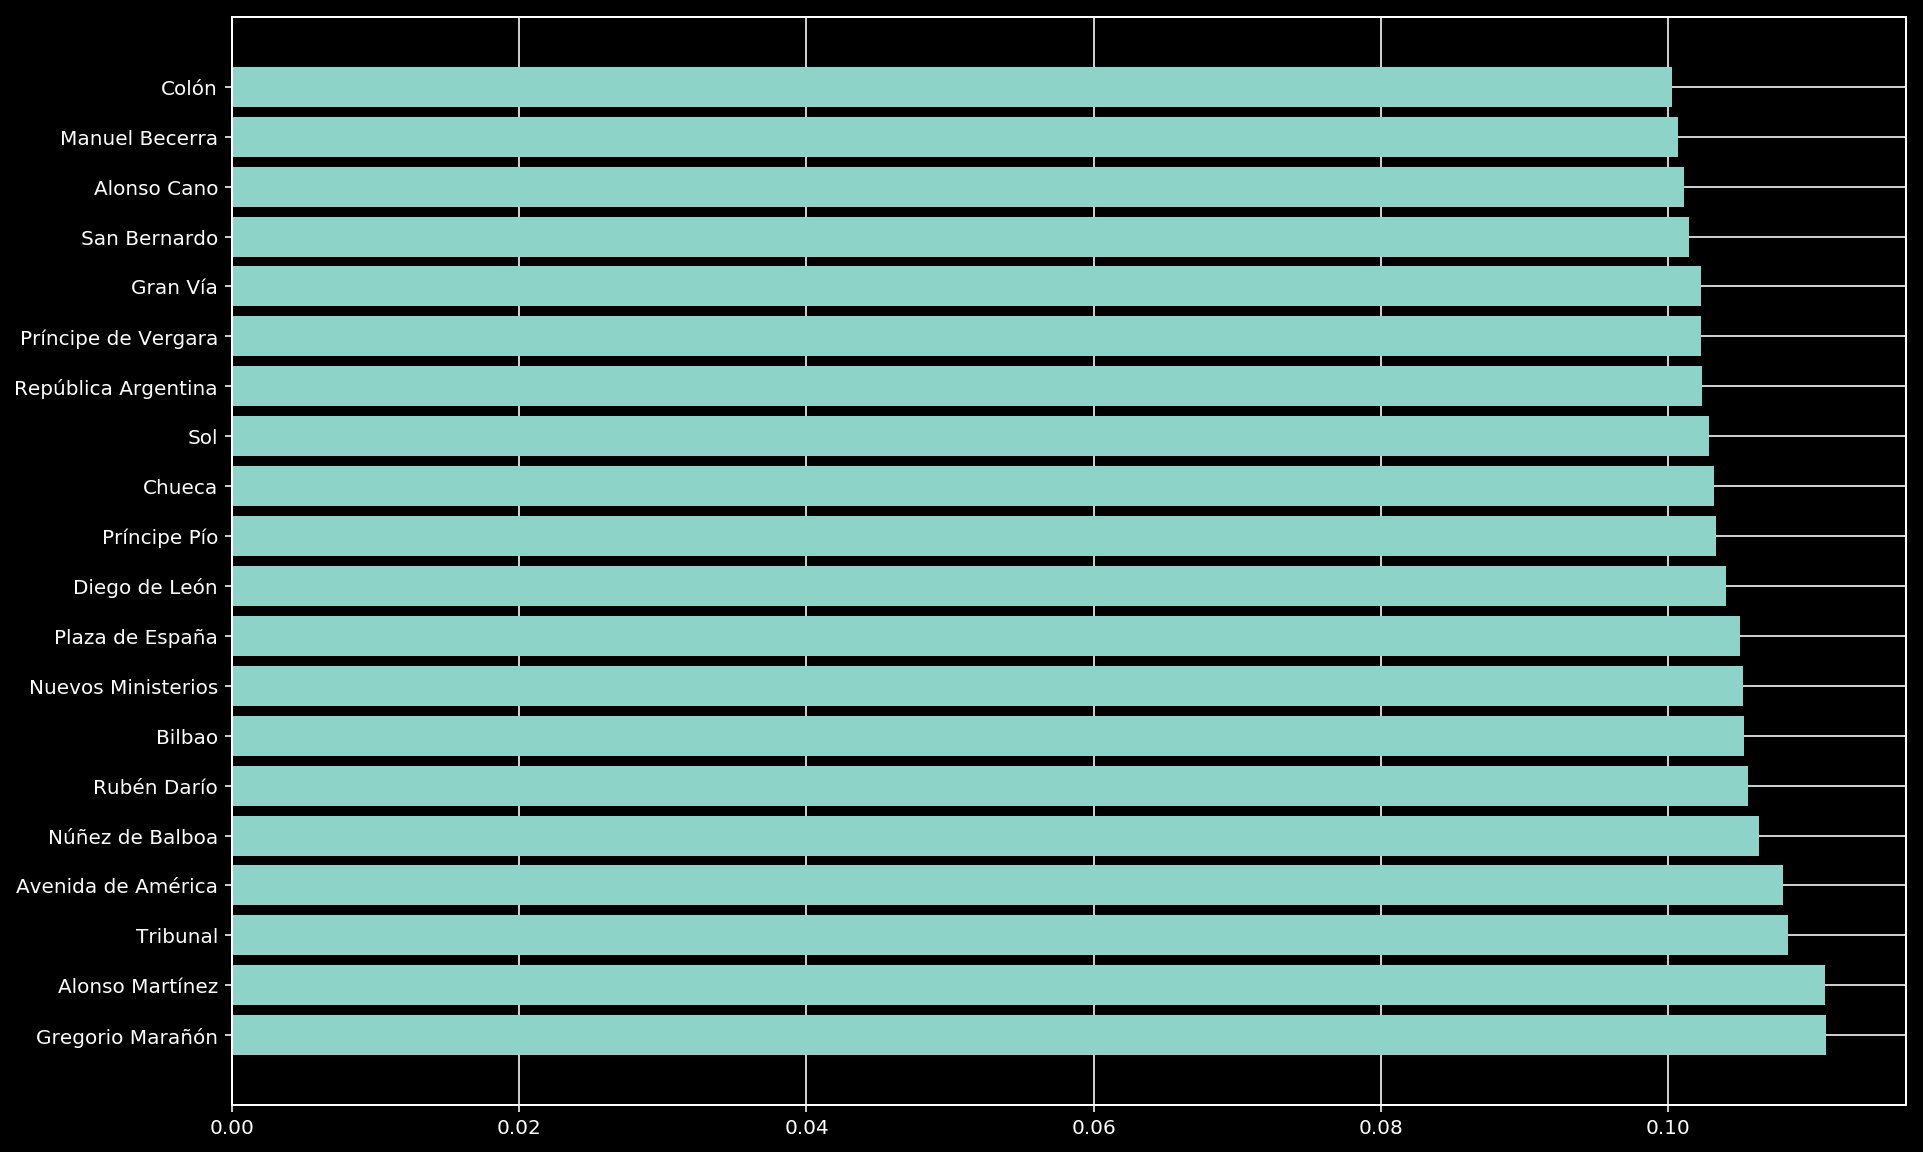

In [33]:
nodesDF = nodesDF.sort_values(by='StationID')
nodesDF['closeness_centrality'] = list(dict(sorted(nx.closeness_centrality(Madrid_tube).items())).values())
plt.figure(figsize=(15,10))
plt.barh(list(range(20)),nodesDF.sort_values(by='closeness_centrality',ascending=False)
         .head(20).closeness_centrality)
plt.yticks(list(range(20)),nodesDF.sort_values(by='closeness_centrality',ascending=False).head(20).StationName)
plt.show()

### What is the Eigenvector Centrality ?

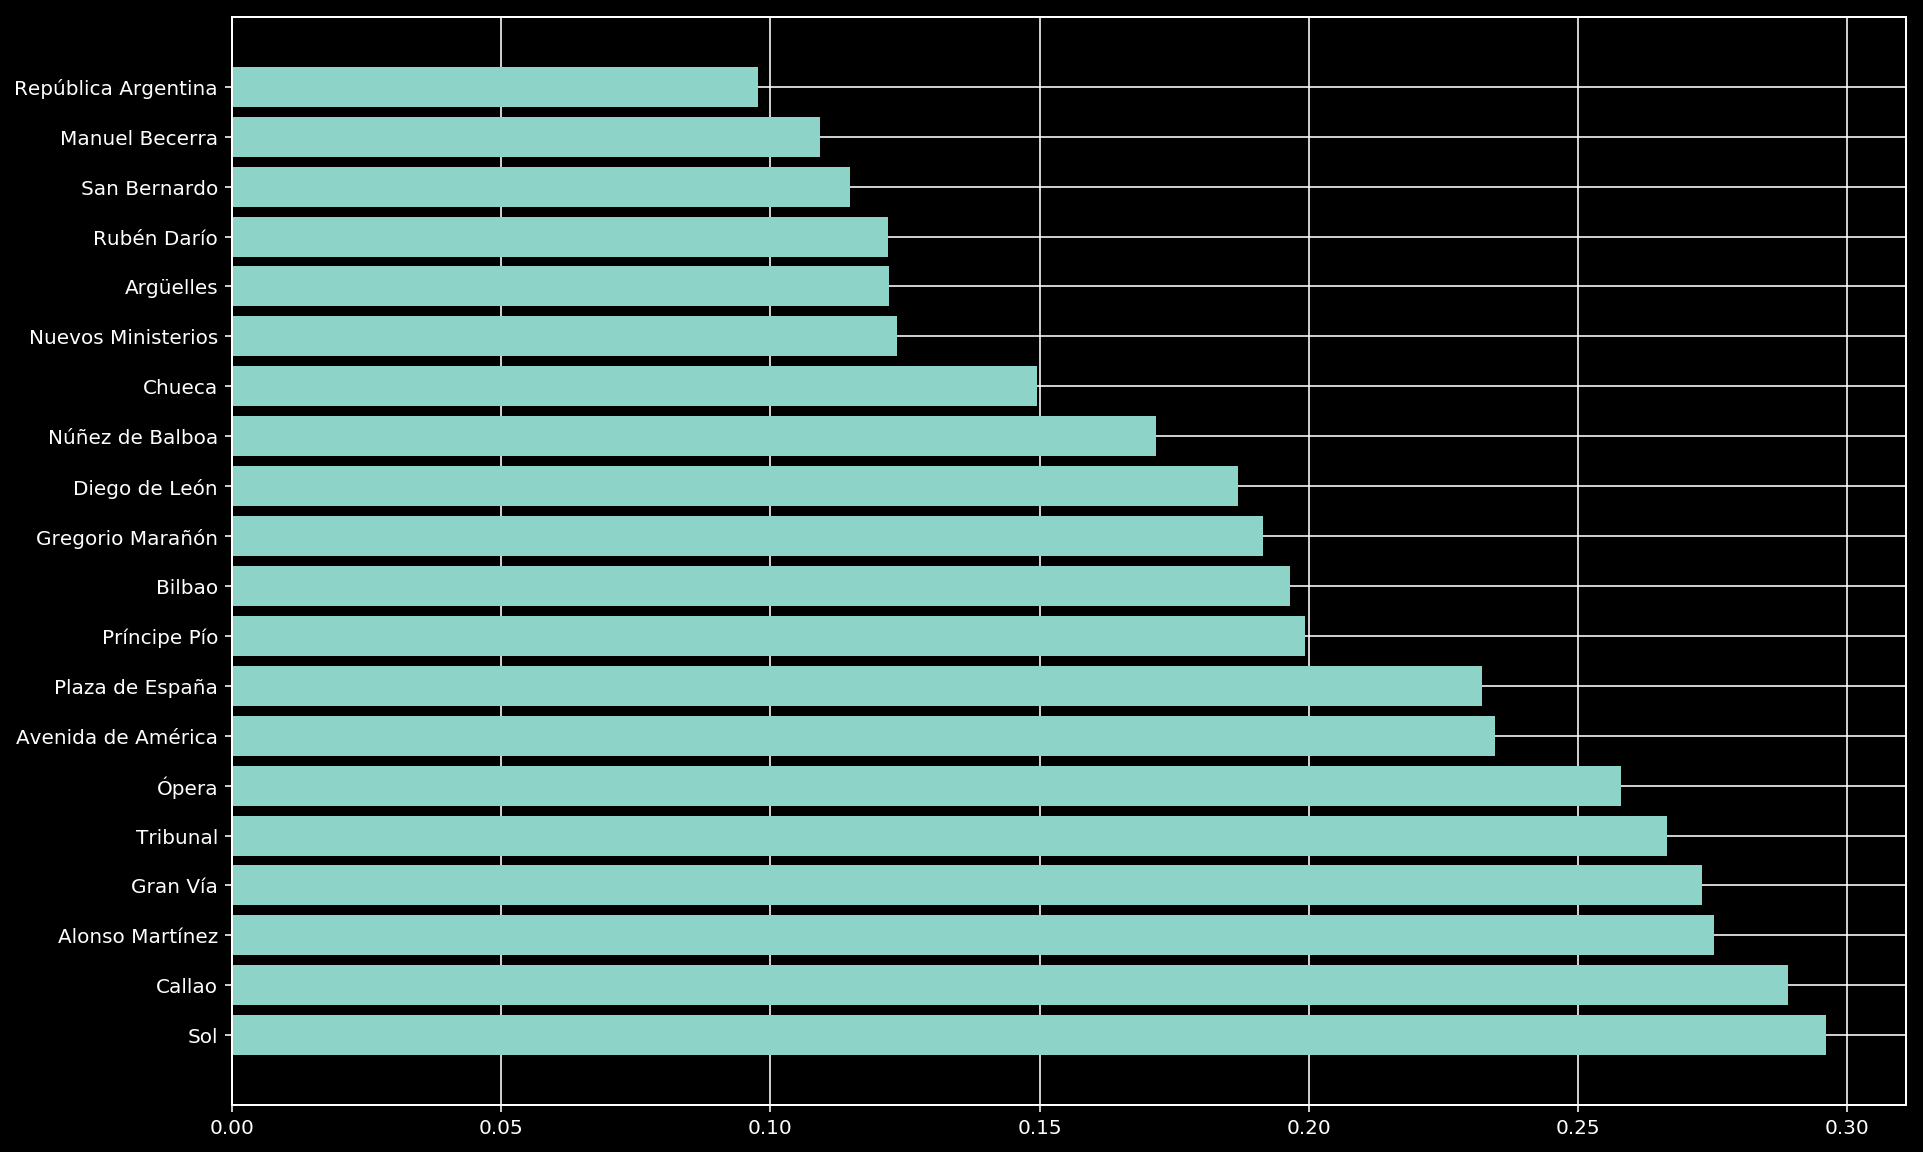

In [34]:
nodesDF = nodesDF.sort_values(by='StationID')
nodesDF['eigenvector_centrality'] = list(dict(sorted(nx.eigenvector_centrality_numpy(Madrid_tube).items())).values())
plt.figure(figsize=(15,10))
plt.barh(list(range(20)),nodesDF.sort_values(by='eigenvector_centrality',ascending=False)
         .head(20).eigenvector_centrality)
plt.yticks(list(range(20)),nodesDF.sort_values(by='eigenvector_centrality',ascending=False).head(20).StationName)
plt.show()

### What is the Average shortest path length ?

In [35]:
#Average shortest path length
nx.average_shortest_path_length(Madrid_tube)

14.583690545591715

### What is the Clusterting coefficient ?

In [36]:
nx.transitivity(Madrid_tube)

0.03325942350332594